In [31]:
import sqlalchemy
import pandas as pd
import json
import pyodbc
import pickle
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm
tqdm.pandas()

from sklearn.preprocessing import StandardScaler

from tensorflow.keras import utils

pd.set_option("display.max_columns", 999)
pd.set_option("display.max_rows", 999)
pd.set_option('float_format', '{:.4f}'.format)

engine = sqlalchemy.create_engine("mssql+pyodbc://ads.otlnal.ru/dds?driver=ODBC+Driver+17+for+SQL+Server?trusted_connection=yes")

# ETL

загружаем признаки, передаваемые Juicy Score

In [2]:
%%time
js_df = pd.read_sql("""select * from [dds].[dbo].[IntegrationJuicyScore]""", engine)

Wall time: 1min 42s


подгружаем целевую переменную

# Default

##  попробуем отделить дефолтных клиентов от хороших

In [3]:
%%time
fpd90 = pd.read_sql("SELECT c.PersonID, c.CreditID, c.DateOpen, iif(p90.[Сумма ОД начальная] is not null and p90.[Кол-во неопл проср дней]>0, 1, 0) as fpd90 " +
"FROM OtlNalWork.dbo.Credit c " +
"left join (select CreditID, [Кол-во неопл проср дней],[Дата состояния], [Сумма ОД начальная] " +
"from [pds].[dbo].[Portfel]) p90 on c.CreditID=p90.CreditID and DATEADD(day,120,cast(c.DateOpen as date))=p90.[Дата состояния] " +
"where c.CredNum = 1 and c.CredStatusID in(5, 6, 7, 9) and c.PointID=523", engine)

Wall time: 4.76 s


In [4]:
js_df.head(2)

,CreditID,js_score,IDX1 Stop Markers,IDX2 User Behaviour Markers,IDX3 Device Markers,IDX4 Connection Markers,IDX5 Device Quality,IDX6 Internet Infrastructure Quality,IDX8 Device Credentials Variability,JavaScript executable,IP available,Useragent available,Supporting data available,Is local country,Timezone mismatch,IP/sim regions match,Duplicating device,Duplicating ip,Duplicating user,Seen before,Same phone,Same login,Same region,Same device,Total applications number,Applications number,Total num of applications with browser hash in 1 day,Total num of applications with browser hash in 7 days,Total num of applications with browser hash in 30 days,Logins number,Phones number,Devices number,Cities number,ZipCodes number,Cards number,Less tenor days,Device ageing with user,Total num of ShortTerm credit applications in 1 day,Total num of ShortTerm credit applications in 7 days,Total num of ShortTerm credit applications in 30 days,Total num of ShortTerm credit applications from ip in 1 day,Total num of ShortTerm credit applications from ip in 7 days,Total num of ShortTerm credit applications from ip in 30 days,Total num of Banking credit applications in 1 day,Total num of Banking credit applications in 7 days,Total num of Banking credit applications in 30 days,Total num of Banking credit applications from ip in 1 day,Total num of Banking credit applications from ip in 7 days,Total num of Banking credit applications from ip in 30 days,Total num of Insurance applications in 1 day,Total num of Insurance applications in 7 days,Total num of Insurance applications in 30 days,Total num of Insurance applications from ip in 1 day,Total num of Insurance applications from ip in 7 days,Total num of Insurance applications from ip in 30 days,Foreign language used,FRD,FRD from diff acc,NPL90+,NPL90+ from diff acc,Is ever FRD,Is mass FRD,Global IP blacklist,Global ISP blacklist,User defined IP blacklist,User defined DeviceID blacklist,User defined UserID blacklist,User defined ISP blacklist,User defined similar DeviceID blacklist,Suspicious Referral,Suspicious Plugins,Suspicious Fonts,Cookie Clone,Mail login length,Mail login marker,Social vector length,Time on page,Number of hot keys,Number of corrections,Browser history count,Is console open,RAM productivity,Storage productivity,Single click,Double click,Context menu,Leave page,Observed quarters,Touch dev,Data manipulation risk,Loan limit utilization,Number of secondary AntiFraud markers,IP Country code,IP Country name,IP Region name,IP City,IP longitude,IP latitude,IP owner,IP domain,IP Mobile brand,IP Usage type,IP Net speed,Proxy,TOR,Real IP,IPv6 usage,IP mismatch,IP ageing in months,DNS Name,DNS IP,Is DNS local,IP zip code,IP zip code distance,Virtual Machine,Is Useragent Structure Issue,Is Randomizer issue,Is Canvas blocker,Is Private mode,Botnet,Connection via browser,Connection via application,Is web view application used,Device type,Device vendor,Device model,Device marketing name,Device manufacturer,Device year release,Mobile device,Touch screen,Display Width via Pixel,Display Height via Pixel,Display Width from manufacturer,Display Height from manufacturer,Usable display Width,Usable display Height,Screen geometry mismatch,Is regular screen resolution,Diagonal screen size,Display ppi,Display pixel ratio,Color Depth via Pixel,Color Depth from manufacturer,RAM size,Hardware Concurrency,NFC,Camera resolution,IP TimeZone,IP TimeZone name,Pixel TimeZone,Device language,Pixel language,OS name,OS version,OS proprietary,Development Platform,Browser name,Browser version,Rendering Engine,IP first seen date
0,4720367,0.1489,0,2,0,1,3,1,3.0000,1.0000,1,1,1,1,1,0,0,1,0,1,1.0000,1.0000,1,1,1,0,0,0,0,1,0,1,1,1,0,0,0,1,1,1,1,5,15,0,0,0,0,2,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,16,0,0,594,0,8,2,0,12500,39.0000,59.0000,7.0000,2.0000,2.0000,4.0000,0.0000,1,0.0000,5,RU,Russian Federation,Krasnoyarskiy kray,Uzhur,89.8300,55.3000,T2 Mobile LLC,cell.ru,Tele2,MOB,DSL,0,0,176.59.147.8,0,0,11,ns1.d

In [5]:
fpd90.head(2)

,PersonID,CreditID,DateOpen,fpd90
0,1065128,3797526,2019-12-29 09:58:00,0
1,1065700,3798196,2019-12-29 17:39:00,1


In [6]:
res = js_df.merge(fpd90, how='left', on='CreditID')

In [7]:
res.tail()

,CreditID,js_score,IDX1 Stop Markers,IDX2 User Behaviour Markers,IDX3 Device Markers,IDX4 Connection Markers,IDX5 Device Quality,IDX6 Internet Infrastructure Quality,IDX8 Device Credentials Variability,JavaScript executable,IP available,Useragent available,Supporting data available,Is local country,Timezone mismatch,IP/sim regions match,Duplicating device,Duplicating ip,Duplicating user,Seen before,Same phone,Same login,Same region,Same device,Total applications number,Applications number,Total num of applications with browser hash in 1 day,Total num of applications with browser hash in 7 days,Total num of applications with browser hash in 30 days,Logins number,Phones number,Devices number,Cities number,ZipCodes number,Cards number,Less tenor days,Device ageing with user,Total num of ShortTerm credit applications in 1 day,Total num of ShortTerm credit applications in 7 days,Total num of ShortTerm credit applications in 30 days,Total num of ShortTerm credit applications from ip in 1 day,Total num of ShortTerm credit applications from ip in 7 days,Total num of ShortTerm credit applications from ip in 30 days,Total num of Banking credit applications in 1 day,Total num of Banking credit applications in 7 days,Total num of Banking credit applications in 30 days,Total num of Banking credit applications from ip in 1 day,Total num of Banking credit applications from ip in 7 days,Total num of Banking credit applications from ip in 30 days,Total num of Insurance applications in 1 day,Total num of Insurance applications in 7 days,Total num of Insurance applications in 30 days,Total num of Insurance applications from ip in 1 day,Total num of Insurance applications from ip in 7 days,Total num of Insurance applications from ip in 30 days,Foreign language used,FRD,FRD from diff acc,NPL90+,NPL90+ from diff acc,Is ever FRD,Is mass FRD,Global IP blacklist,Global ISP blacklist,User defined IP blacklist,User defined DeviceID blacklist,User defined UserID blacklist,User defined ISP blacklist,User defined similar DeviceID blacklist,Suspicious Referral,Suspicious Plugins,Suspicious Fonts,Cookie Clone,Mail login length,Mail login marker,Social vector length,Time on page,Number of hot keys,Number of corrections,Browser history count,Is console open,RAM productivity,Storage productivity,Single click,Double click,Context menu,Leave page,Observed quarters,Touch dev,Data manipulation risk,Loan limit utilization,Number of secondary AntiFraud markers,IP Country code,IP Country name,IP Region name,IP City,IP longitude,IP latitude,IP owner,IP domain,IP Mobile brand,IP Usage type,IP Net speed,Proxy,TOR,Real IP,IPv6 usage,IP mismatch,IP ageing in months,DNS Name,DNS IP,Is DNS local,IP zip code,IP zip code distance,Virtual Machine,Is Useragent Structure Issue,Is Randomizer issue,Is Canvas blocker,Is Private mode,Botnet,Connection via browser,Connection via application,Is web view application used,Device type,Device vendor,Device model,Device marketing name,Device manufacturer,Device year release,Mobile device,Touch screen,Display Width via Pixel,Display Height via Pixel,Display Width from manufacturer,Display Height from manufacturer,Usable display Width,Usable display Height,Screen geometry mismatch,Is regular screen resolution,Diagonal screen size,Display ppi,Display pixel ratio,Color Depth via Pixel,Color Depth from manufacturer,RAM size,Hardware Concurrency,NFC,Camera resolution,IP TimeZone,IP TimeZone name,Pixel TimeZone,Device language,Pixel language,OS name,OS version,OS proprietary,Development Platform,Browser name,Browser version,Rendering Engine,IP first seen date,PersonID,DateOpen,fpd90
12537,4848500,0.3508,0,0,0,3,4,1,NaN,1.0000,1,1,1,1,1,0,0,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,6,0,0,271,0,15,3,0,21100,326.0000,22.0000,0.0000,0.0000,2.0000,3.0000,2.7170,1,0.0000,4,RU,Russian Federation,Tatarstan Respublika,Mendeleyevsk,52.2900,55.9100,PJSC MegaFon,megafon.ru,MegaFon,ISP/M

In [8]:
res.fillna(-1, inplace=True)

In [50]:
res['fpd90'].value_counts()

0.0000     10114
1.0000      2417
-1.0000       11
Name: fpd90, dtype: int64

In [104]:
res.shape

(12542, 164)

# Feature engeneering

Разбиваем на категориальные и непрерывные признаки

In [10]:
cat_feats = [
    'IDX1 Stop Markers', 'IDX2 User Behaviour Markers', 'IDX3 Device Markers', 'IDX4 Connection Markers', 'IDX5 Device Quality', 'IDX6 Internet Infrastructure Quality',
    'IDX8 Device Credentials Variability', 'Is local country', 'Timezone mismatch',
    'IP/sim regions match', 'Duplicating device', 'Duplicating ip', 'Duplicating user', 'Seen before', 'Same phone', 'Same login', 'Same region', 'Same device',
    'Less tenor days', 'Foreign language used', 'FRD', 'FRD from diff acc', 'Is ever FRD', 'Is mass FRD', 'Global IP blacklist', 'Global ISP blacklist', 'Suspicious Plugins',
    'Suspicious Fonts', 'Cookie Clone', 'Mail login marker', 'Is console open', 'Observed quarters', 'Proxy', 'TOR', 'IPv6 usage', 'IP mismatch', 'Is DNS local',
    'Is Useragent Structure Issue', 'Is Randomizer issue', 'Is Canvas blocker', 'Is Private mode', 'Botnet', 'Connection via browser', 'Connection via application',
    'Is web view application used', 'Mobile device', 'Touch screen', 'Screen geometry mismatch', 'Is regular screen resolution', 'Color Depth via Pixel', 
    'Color Depth from manufacturer', 'RAM size', 'NFC'
]

In [11]:
cont_feats = [
    'js_score', 'Total applications number', 'Applications number', 'Total num of applications with browser hash in 1 day', 'Total num of applications with browser hash in 7 days',
    'Total num of applications with browser hash in 30 days', 'Logins number', 'Phones number', 'Devices number', 'Cities number', 'ZipCodes number', 'Device ageing with user',
    'Total num of ShortTerm credit applications in 1 day', 'Total num of ShortTerm credit applications in 7 days', 'Total num of ShortTerm credit applications in 30 days',
    'Total num of ShortTerm credit applications from ip in 1 day', 'Total num of ShortTerm credit applications from ip in 7 days',
    'Total num of ShortTerm credit applications from ip in 30 days', 'Total num of Banking credit applications in 1 day', 'Total num of Banking credit applications in 7 days',
    'Total num of Banking credit applications in 30 days', 'Total num of Banking credit applications from ip in 1 day', 'Total num of Banking credit applications from ip in 7 days',
    'Total num of Banking credit applications from ip in 30 days', 'Total num of Insurance applications from ip in 1 day', 'Total num of Insurance applications from ip in 7 days',
    'Total num of Insurance applications from ip in 30 days', 'Mail login length', 'Time on page', 'Number of hot keys', 'Number of corrections', 'Browser history count', 
    'RAM productivity', 'Storage productivity', 'Single click', 'Double click', 'Context menu', 'Leave page', 'Touch dev', 'Number of secondary AntiFraud markers',
    'IP longitude', 'IP latitude', 'IP ageing in months', 'IP zip code distance', 'Device year release', 'Display Width via Pixel', 'Display Height via Pixel',
    'Display Width from manufacturer', 'Display Height from manufacturer', 'Usable display Width', 'Usable display Height', 'Diagonal screen size', 'Display ppi',
    'Display pixel ratio', 'Hardware Concurrency', 'Camera resolution', 'IP TimeZone', 'Pixel TimeZone', 'IP first seen date'
             ]

In [12]:
target_col = ['fpd90']

In [13]:
for i in[i for i in res.select_dtypes(exclude=object).columns if i not in cat_feats and i != 'CreditID' and i not in cont_feats and res[i].nunique() > 1]:
    print(f"{i} - {res[i].nunique()}")

JavaScript executable - 2
PersonID - 12532
fpd90 - 3


определяем функцию для кодирования категориальных признаков в OneHotEncoding

In [14]:
def cat_feats_to_ohe(feat:str, value):
    num_classes = res[feat].nunique()
    class_dict = dict(zip(list(res[feat].value_counts().index), range(num_classes)))
    outClass = class_dict[value]
    return utils.to_categorical(max(0, min(num_classes,outClass)), num_classes).astype('int')

In [15]:
res_scaled = res[cat_feats + cont_feats + target_col].copy()

In [16]:
res_scaled.shape

(12542, 113)

Разбиваем на нормальных клиентов и дефолтных

In [21]:
good_df = res_scaled[res_scaled[target_col[0]] == 0]
bad_df = res_scaled[res_scaled[target_col[0]] == 1]

In [22]:
good_df.shape, bad_df.shape

((10114, 113), (2417, 113))

## Scale

стандартизируем непрерывные признаки

In [23]:
scaler = StandardScaler()

In [24]:
good_df[cont_feats] = scaler.fit_transform(good_df[cont_feats])
bad_df[cont_feats] = scaler.transform(bad_df[cont_feats])

c:\users\s.sashchenko\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
c:\users\s.sashchenko\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [25]:
good_df

,IDX1 Stop Markers,IDX2 User Behaviour Markers,IDX3 Device Markers,IDX4 Connection Markers,IDX5 Device Quality,IDX6 Internet Infrastructure Quality,IDX8 Device Credentials Variability,Is local country,Timezone mismatch,IP/sim regions match,Duplicating device,Duplicating ip,Duplicating user,Seen before,Same phone,Same login,Same region,Same device,Less tenor days,Foreign language used,FRD,FRD from diff acc,Is ever FRD,Is mass FRD,Global IP blacklist,Global ISP blacklist,Suspicious Plugins,Suspicious Fonts,Cookie Clone,Mail login marker,Is console open,Observed quarters,Proxy,TOR,IPv6 usage,IP mismatch,Is DNS local,Is Useragent Structure Issue,Is Randomizer issue,Is Canvas blocker,Is Private mode,Botnet,Connection via browser,Connection via application,Is web view application used,Mobile device,Touch screen,Screen geometry mismatch,Is regular screen resolution,Color Depth via Pixel,Color Depth from manufacturer,RAM size,NFC,js_score,Total applications number,Applications number,Total num of applications with browser hash in 1 day,Total num of applications with browser hash in 7 days,Total num of applications with browser hash in 30 days,Logins number,Phones number,Devices number,Cities number,ZipCodes number,Device ageing with user,Total num of ShortTerm credit applications in 1 day,Total num of ShortTerm credit applications in 7 days,Total num of ShortTerm credit applications in 30 days,Total num of ShortTerm credit applications from ip in 1 day,Total num of ShortTerm credit applications from ip in 7 days,Total num of ShortTerm credit applications from ip in 30 days,Total num of Banking credit applications in 1 day,Total num of Banking credit applications in 7 days,Total num of Banking credit applications in 30 days,Total num of Banking credit applications from ip in 1 day,Total num of Banking credit applications from ip in 7 days,Total num of Banking credit applications from ip in 30 days,Total num of Insurance applications from ip in 1 day,Total num of Insurance applications from ip in 7 days,Total num of Insurance applications from ip in 30 days,Mail login length,Time on page,Number of hot keys,Number of corrections,Browser history count,RAM productivity,Storage productivity,Single click,Double click,Context menu,Leave page,Touch dev,Number of secondary AntiFraud markers,IP longitude,IP latitude,IP ageing in months,IP zip code distance,Device year release,Display Width via Pixel,Display Height via Pixel,Display Width from manufacturer,Display Height from manufacturer,Usable display Width,Usable display Height,Diagonal screen size,Display ppi,Display pixel ratio,Hardware Concurrency,Camera resolution,IP TimeZone,Pixel TimeZone,IP first seen date,fpd90
2,0,3,0,0,2,2,3.0000,1,0,1,0,0,0,1,1.0000,1.0000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0000,0,0,0,0,1.0000,0,0,-1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0,1,24.0000,-1.0000,4.0000,-1.0000,0.6309,-0.0390,-0.0365,-0.1992,-0.2564,-0.2546,-0.5609,-0.2111,-0.4587,-0.7183,0.3376,-0.0684,-0.2855,0.5715,0.0148,-0.4278,0.2498,-0.4447,-0.0199,-0.0424,-0.0906,-0.1769,-0.3846,0.0511,-0.0263,-0.0506,-0.0653,-1.0644,0.0419,-0.1991,0.4011,-0.5647,0.2136,-0.4495,0.0221,-0.1426,-0.2470,-0.4466,-0.3750,-1.5907,-0.6865,0.2316,-0.4641,-0.5250,-2.4683,3.5030,2.4647,-1.6590,-1.4988,-1.8716,-1.6447,-2.2398,-1.8127,-1.9709,-0.2793,-0.9330,-0.6617,-0.6962,-0.4670,0.0000
3,0,1,0,0,2,1,3.0000,1,0,0,0,0,0,1,1.0000,1.0000,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,4.0000,0,0,1,0,1.0000,0,0,-1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1,1,24.0000,24.0000,4.0000,0.0000,-0.9197,0.7754,-0.0365,-0.1992,-0.2564,-0.2546,1.3692,-0.2111,-0.4587,1.6089,0.3376,-0.2829,-0.2855,-0.3144,0.0148,0.9372,0.7015,2.0442,-0.0199,-0.0424,-0.0906,-0.1769,1.3875,1.3295,-0.0263,-0.0506,-0.0653,-0.0496,0.0810,1.5190,-0.7197,-0.5647,-0.7493,-0.4716,0.0794,-0.1426,3.5801,-0.9858,-0.2332,1.5673,-0.6651,-1.9277,-0.5268,-0.2929,0.4041,-0.2233,0.5882,0.9957,0.8741,0.4972,0.5839,0.5696,0.9625,-0.9487,0.7594,-0.0036,-0.6617,-0.6962,

Создаём результирующий вектор для каждой строки

In [27]:
def create_vector(row):
    out = []
    for f_col in cat_feats:
        out.extend(cat_feats_to_ohe(f_col, row[f_col]))
    for c_col in cont_feats:
        out.append(row[c_col])
        
    return np.array(out)

In [32]:
good_df['res'] = good_df.progress_apply(create_vector, axis=1)

100%|████████████████████████████████████████████████████████████████████████████| 10114/10114 [03:50<00:00, 43.78it/s]
c:\users\s.sashchenko\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [33]:
bad_df['res'] = bad_df.progress_apply(create_vector, axis=1)

100%|██████████████████████████████████████████████████████████████████████████████| 2417/2417 [00:55<00:00, 43.33it/s]


In [35]:
good_df.iloc[0]['res'].shape

(227,)

# NN

In [37]:
from tensorflow.keras.models import Model, Sequential # загружаем абстрактный класс базовой модели сети от кераса и последовательную модель
# Из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K # подтягиваем базовые керасовские функции
from tensorflow.keras.optimizers import Adam # загружаем выбранный оптимизатор
from tensorflow.keras import utils # загружаем утилиты кераса
from tensorflow.keras.datasets import mnist, fashion_mnist # загружаем готовые базы mnist
from tensorflow.keras.callbacks import LambdaCallback

import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения
import numpy as np # библиотека для работы с массивами данных
import pandas as pd # библиотека для анализа и обработки данных
from PIL import Image # модуль для отрисовки изображения
from sklearn.model_selection import train_test_split # модуль для разбивки выборки на тренировочную/тестовую
from sklearn.preprocessing import StandardScaler # модуль для стандартизации данных

import os #
import time, random
import seaborn as sns
sns.set_style('darkgrid')

формируем выборки

In [52]:
normal = pd.DataFrame.from_records(good_df['res'].values).values
frauds = pd.DataFrame.from_records(bad_df['res'].values).values

In [53]:
normal.shape, frauds.shape

((10114, 227), (2417, 227))

In [54]:
RANDOM_SEED = 42 # задаем случайное значение
# берём нормальные операции и разбиваем на train_test(только 'X')
X_train, X_test = train_test_split(normal, test_size=0.1, random_state=RANDOM_SEED)

In [55]:
X_train.shape, X_test.shape

((9102, 227), (1012, 227))

In [57]:
# Добавляем все мошеннические транзакции в тестовый набор данных
X_test = np.concatenate([X_test, frauds])

In [58]:
X_test.shape

(3429, 227)

In [74]:
def creditcardAutoencoder(lr=0.0001): # объявляем автокодировщик для определения мошенич.транзакций
    dataSize = X_train.shape[1] # берём размеры X_train по второй оси
    dataInput = Input(shape=(dataSize, )) # задаем эти размеры как входные в сеть

    x = Dense(64, activation='relu')(dataInput) # пропускаем через полносвязный слой размером 
    x = Dense(10, activation='relu')(x) # пропускаем через полносвязный слой размером 10
    x = Dense(64, activation='relu')(x) # пропускаем через полносвязный слой размером 10
    x = Dense(dataSize, activation='linear')(x) # и через полносвязный слой размером 29 

    autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 

    autoencoder.compile(optimizer='Adam', loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки

    return autoencoder 

In [75]:
model = creditcardAutoencoder()

In [76]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 227)]             0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                14592     
_________________________________________________________________
dense_17 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_18 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_19 (Dense)             (None, 227)               14755     
Total params: 30,701
Trainable params: 30,701
Non-trainable params: 0
_________________________________________________________________


In [79]:
history = model.fit(X_train, X_train,
                    epochs=5000,
                    batch_size=512, 
                    workers=-1) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/5000
18/18 [==============================] - 0s 2ms/step - loss: 0.0715
Epoch 2/5000
18/18 [==============================] - 0s 2ms/step - loss: 0.0690
Epoch 3/5000
18/18 [==============================] - 0s 2ms/step - loss: 0.0678
Epoch 4/5000
18/18 [==============================] - 0s 2ms/step - loss: 0.0674
Epoch 5/5000
18/18 [==============================] - 0s 883us/step - loss: 0.0672
Epoch 6/5000
18/18 [==============================] - 0s 912us/step - loss: 0.0671
Epoch 7/5000
18/18 [==============================] - 0s 1ms/step - loss: 0.0670
Epoch 8/5000
18/18 [==============================] - 0s 1ms/step - loss: 0.0670
Epoch 9/5000
18/18 [==============================] - 0s 912us/step - loss: 0.0670
Epoch 10/5000
18/18 [==============================] - 0s 919us/step - loss: 0.0670
Epoch 11/5000
18/18 [==============================] - 0s 919us/step - loss: 0.0669
Epoch 12/5000
18/18 [==============================] - 0s 2ms/step - loss: 0.0669
Epoch 13/5000
1

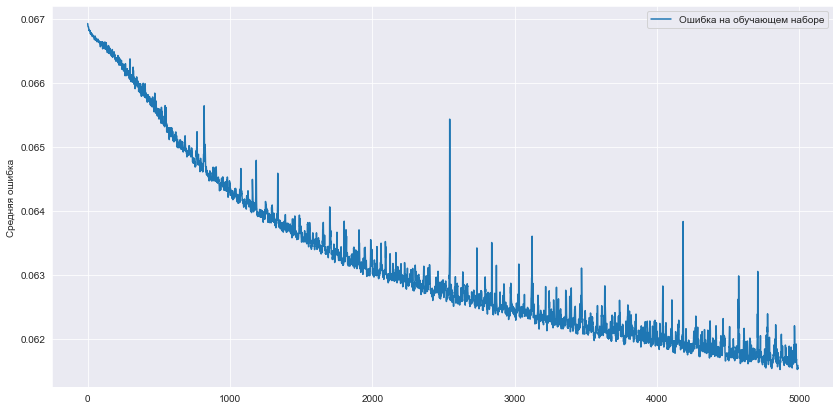

In [80]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][10:], 
         label='Ошибка на обучающем наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [81]:
model.save_weights('model_1.h5')

In [85]:
X_train_norm, X_test_norm = train_test_split(normal, test_size=0.1, random_state=RANDOM_SEED)

In [87]:
predictions_norm = model.predict(X_test_norm) # делаем предсказание по X_test
predictions_frauds = model.predict(frauds) # делаем предсказание по X_test

In [88]:
mse_normal = np.mean(np.power(X_test_norm - predictions_norm, 2), axis=1) # среднеквадратичная ошибка на нормальных операциях
mse_frauds = np.mean(np.power(frauds - predictions_frauds, 2), axis=1) # среднеквадратичная ошибка на фродовых операциях

In [105]:
print("Минимальная ошибка нормальных клиентов:", round(min(mse_normal),4)) #найдем минимальную среднеквадратичную ошибку на нормальных операциях
print("Максимальная ошибка нормальных клиентов:", round(max(mse_normal),4)) #найдем максимальную среднеквадратичную ошибку на нормальных операциях
print("Средняя ошибка нормальных клиентов:", round(sum(mse_normal) / len(mse_normal),4)) # среднюю ошибку

Минимальная ошибка нормальных клиентов: 0.011
Максимальная ошибка нормальных клиентов: 6.0542
Средняя ошибка нормальных клиентов: 0.079


In [106]:
print("Минимальная ошибка мошеннических клиентов:", round(min(mse_frauds),4)) #найдем минимальную среднеквадратичную ошибку на мошеннических операциях
print("Максимальная ошибка мошеннических клиентов:", round(max(mse_frauds),4)) #найдем максимальную среднеквадратичную ошибку на мошеннических операциях
print("Средняя ошибка мошеннических клиентов:", round(sum(mse_frauds) / len(mse_frauds),4)) # среднюю ошибку

Минимальная ошибка мошеннических клиентов: 0.0103
Максимальная ошибка мошеннических клиентов: 788.6783
Средняя ошибка мошеннических клиентов: 0.4501


In [107]:
def getAccByBias(bias): # функция будет принимать какое то пороговое значение
    isNormal = mse_normal < bias # если ошибка меньше порога - то транзакция нормальная
    isFrauds = mse_frauds > bias # если ошибка больше порога - то транзакция мошенническая

    accNormal = sum(isNormal) / len(isNormal) # вычисляем процент нормальных операций
    accFaruds = sum(isFrauds) / len(isFrauds) # вычисляем процент мошеннических операций

    print("Распознано нормальных клиентов: ", round(100*accNormal), "%", sep="")
    print("Распознано мошеннических клиентов: ", round(100*accFaruds), "%", sep="")
    print("Средняя точность распознавания: ", round(50*(accNormal + accFaruds)), "%", sep="")
    return round(50*(accNormal + accFaruds))

In [108]:
getAccByBias(0.15) # выведем данные по распознаванию с конкретным пороговым значением

Распознано нормальных клиентов: 95%
Распознано мошеннических клиентов: 11%
Средняя точность распознавания: 53%


53

# Black List

## отделим мошенников от нормальных клиентов

подгружаем базу мошенников

In [112]:
black_list = pd.read_sql("select * from Skoring.dbo.PersonsFromSessionsBlacklist", engine)

In [118]:
bl = black_list[(black_list['FromSession'] != 'called_from_cc') & (black_list['DateInsert'] < '2021-08-26')]['PersonID'].to_list()

In [119]:
len(bl)

5605

проставляем флаг мошенник клиент или нет

In [121]:
res['bl'] = res['PersonID'].apply(lambda x: 1 if x in bl else 0)

In [122]:
res['bl'].value_counts()

0    12432
1      110
Name: bl, dtype: int64

In [124]:
res_bl = res[cat_feats + cont_feats + ['bl']].copy()

In [125]:
res_bl.shape

(12542, 113)

делим на хороших и фрод

In [126]:
good_df = res_bl[res_bl['bl'] == 0]
bad_df = res_bl[res_bl['bl'] == 1]

In [127]:
good_df.shape, bad_df.shape

((12432, 113), (110, 113))

Стандартизируем

In [128]:
scaler = StandardScaler()

In [129]:
good_df[cont_feats] = scaler.fit_transform(good_df[cont_feats])
bad_df[cont_feats] = scaler.transform(bad_df[cont_feats])

c:\users\s.sashchenko\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
c:\users\s.sashchenko\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Создаем результирующие вектора

In [130]:
good_df['res'] = good_df.progress_apply(create_vector, axis=1)
bad_df['res'] = bad_df.progress_apply(create_vector, axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 43.46it/s]


In [131]:
normal = pd.DataFrame.from_records(good_df['res'].values).values
frauds = pd.DataFrame.from_records(bad_df['res'].values).values

In [132]:
RANDOM_SEED = 42 # задаем случайное значение
# берём нормальные операции и разбиваем на train_test(только 'X')
X_train, X_test = train_test_split(normal, test_size=0.2, random_state=RANDOM_SEED)

In [133]:
X_train.shape, X_test.shape

((9945, 227), (2487, 227))

In [134]:
# Добавляем все мошеннические транзакции в тестовый набор данных
X_test = np.concatenate([X_test, frauds])

создаем модель

In [135]:
model_bl = creditcardAutoencoder()

In [136]:
history_bl = model_bl.fit(X_train, X_train,
                    epochs=5000,
                    batch_size=512, 
                    workers=-1) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.4630
Epoch 2/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.3370
Epoch 3/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.2870
Epoch 4/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.2614
Epoch 5/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.2399
Epoch 6/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.2191
Epoch 7/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.2038
Epoch 8/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.1928
Epoch 9/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.1846
Epoch 10/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.1782
Epoch 11/5000
20/20 [==============================] - 0s 1ms/step - loss: 0.1729
Epoch 12/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.1686
Epoch 13/5000
20/20 [====

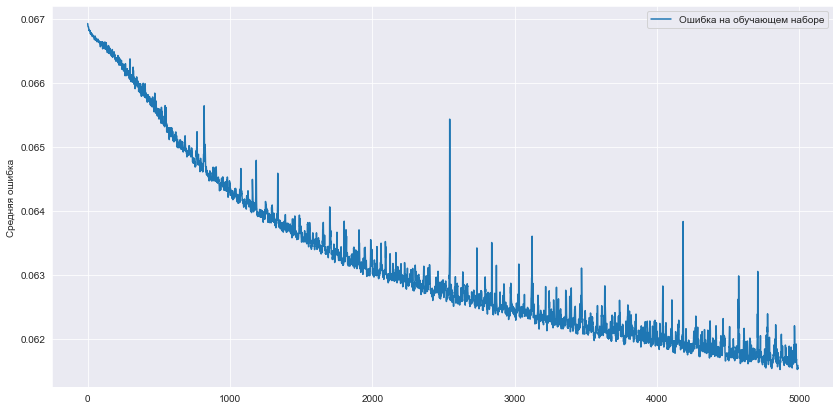

In [137]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][10:], 
         label='Ошибка на обучающем наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [138]:
model.save_weights('model_bl.h5')

In [142]:
X_train_norm, X_test_norm = train_test_split(normal, test_size=0.2, random_state=RANDOM_SEED)

In [143]:
predictions_norm = model.predict(X_test_norm) # делаем предсказание по X_test
predictions_frauds = model.predict(frauds) # делаем предсказание по X_test

In [144]:
mse_normal = np.mean(np.power(X_test_norm - predictions_norm, 2), axis=1) # среднеквадратичная ошибка на нормальных операциях
mse_frauds = np.mean(np.power(frauds - predictions_frauds, 2), axis=1) # среднеквадратичная ошибка на фродовых операциях

In [145]:
print("Минимальная ошибка нормальных клиентов:", round(min(mse_normal),4)) #найдем минимальную среднеквадратичную ошибку на нормальных операциях
print("Максимальная ошибка нормальных клиентов:", round(max(mse_normal),4)) #найдем максимальную среднеквадратичную ошибку на нормальных операциях
print("Средняя ошибка нормальных клиентов:", round(sum(mse_normal) / len(mse_normal),4)) # среднюю ошибку

Минимальная ошибка нормальных клиентов: 0.0103
Максимальная ошибка нормальных клиентов: 1.2603
Средняя ошибка нормальных клиентов: 0.0666


In [146]:
print("Минимальная ошибка мошеннических клиентов:", round(min(mse_frauds),4)) #найдем минимальную среднеквадратичную ошибку на мошеннических операциях
print("Максимальная ошибка мошеннических клиентов:", round(max(mse_frauds),4)) #найдем максимальную среднеквадратичную ошибку на мошеннических операциях
print("Средняя ошибка мошеннических клиентов:", round(sum(mse_frauds) / len(mse_frauds),4)) # среднюю ошибку

Минимальная ошибка мошеннических клиентов: 0.0246
Максимальная ошибка мошеннических клиентов: 41.5363
Средняя ошибка мошеннических клиентов: 2.4211


In [148]:
getAccByBias(0.19) # выведем данные по распознаванию с конкретным пороговым значением

Распознано нормальных клиентов: 98%
Распознано мошеннических клиентов: 85%
Средняя точность распознавания: 92%


92